## Worksheet 7

### Group 22 Eaton Heidegger and Shannon Schröder

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from numba import stencil, njit


### Poisson equation
#### N-body gravity solver

a)  Generate a model cluster of N stars (choose N as large as is feasible given your computational
 resources, e.g. N = 1000). Compute the 3D gravitational potential of the sampled cluster using
 the Green’s function approach. The analytical solution to the potential of a Plummer sphere
 is (in ‘N-body units’)

Greens function approach: 

If you have a linear differential equation of the form:
$L u(x) = f(x)$

where:

- $L$ is a linear differential operator (like the Laplacian $\nabla^2$ or a time derivative),
- $u(x)$ is the unknown function,
- $f(x)$ is a known source function,

then the Green’s function $G(x, x')$ is the solution to:

$L G(x, x') = \delta(x - x')$

where $\delta(x - x')$ is the Dirac delta function, representing a point source at position x'. 


(-10.0, 10.0)

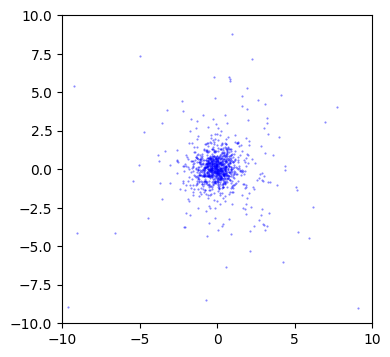

In [81]:
# Sample Plumber from provided Notebook :

# initialise the random number generator
rng = np.random.Generator(np.random.PCG64(seed=12345))

# Sample isotropic 3d vectors with a given modulus
def rand_vec3d( mod ):
    N = len(mod)
    phi = 2*np.pi*rng.random(size=N)
    theta = np.arccos( 2*rng.random(size=N)-1 )
    v3d = np.zeros( (N,3) )
    v3d[:,0] = mod * np.cos( phi ) * np.sin( theta )
    v3d[:,1] = mod * np.sin( phi ) * np.sin( theta )
    v3d[:,2] = mod * np.cos( theta )
    # subtract mean
    for i in range(3):
        v3d[:,i] -= np.mean(v3d[:,i])
    return v3d

# number of stars
N = 1000

# particle mass is 1/N
m = 1/N

# Sampling the mass, draw radii through inversion sampling from the cumulative mass M
U = rng.random(size=N)
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )
positions = x3d
# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

Compute the 3D potential numerically via Green's function

The gravitational potential $\Phi(r)$ at a point $\vec{r}$ is: 

$\Phi(r) = - G \sum_{j \neq i}^N \frac{Gm}{|r_i - r_j|}$

In N body units: G = 1, m = 1/N (used WS 5)

The Green's functiton for gravitational potential is: 

$\Phi(r) = - \frac{1}{N} \sum_{j \neq i}^N \frac{1}{|r_i - r_j| + \epsilon^2}$

This is the numerical potential at position $r_i$, due to all other particles, softened with $\epsilon$ (which could be set to zero or a small value to avoid singularities). Because we exclude i = j to avoid singularities we can set $\epsilon$ to 0.


For the accelertion: $a(x) = - (\nabla \Phi)(x)$: 

$\vec{a}_j = - \nabla \Phi_j =- \frac{1}{N} \sum_{j \neq i}^N \frac{r_j-r_i}{|r_i - r_j|^3} $

In [ ]:
def compute_potential(positions):
    """
    Compute the gravitational potential and acceleration for a system of N particles
    using the Green's function approach in N-body units (G = 1, M = 1, m = 1/N).

    Parameters
    ----------
    positions : ndarray
        Array of shape (N, 3) containing 3D positions of the particles.

    Returns
    -------
    phi : ndarray
        Gravitational potential at each particle position (N,).
    acc : ndarray
        Acceleration vectors for each particle (N, 3).
    """
    N = positions.shape[0]
    m = 1/N

    # Compute pairwise position differences: shape (N, N, 3)
    dx = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # r_i - r_j

    # Compute pairwise distances: shape (N, N)
    r = np.linalg.norm(dx, axis=2)

    # Avoid division by zero for self-interaction by setting diagonals to inf
    np.fill_diagonal(r, np.inf)
    # Distance matrix (NxN)
    #r_ij = cdist(x3d, x3d)
    # Potential: φ_j = -m * sum_i≠j 1/|r_j - r_i|
    phi = -1/N * np.sum(1 / r, axis=1)
    # Acceleration: a_j = -m * sum_i≠j (r_j - r_i) / |r_j - r_i|^3
    r3 = r**3
    acc = -m * np.sum(dx / r3[:, :, np.newaxis], axis=1)
    
    return phi, acc


Checkthat the potential computed for each star agrees on average (due to random sampling there will be fluctuations) with the expected gravitational potential at its location. 

In [85]:
# Compute numerical potential
phi_num, acc = compute_potential(x3d)

Compute the analytical Plummer potential: 

$\Phi_P(r) = - \frac{1}{\sqrt{1+r^2}}$

In [89]:
# Compute analytical Plummer potential at same positions
radii = np.linalg.norm(x3d, axis=1)
phi_analytic = -1 / np.sqrt(1 + radii**2)

In [90]:
# Compute mean and standard deviation of residuals
residuals = phi_num - phi_analytic
mean_diff = np.mean(residuals)
std_diff = np.std(residuals)
rel_error = np.mean(np.abs(residuals / phi_analytic))

print(f"Mean difference (Φ_numerical - Φ_analytic): {mean_diff:.4e}")
print(f"Std. deviation of difference: {std_diff:.4e}")
print(f"Mean relative error: {rel_error:.4%}")

Mean difference (Φ_numerical - Φ_analytic): -6.4295e-03
Std. deviation of difference: 1.9670e-02
Mean relative error: 2.3966%


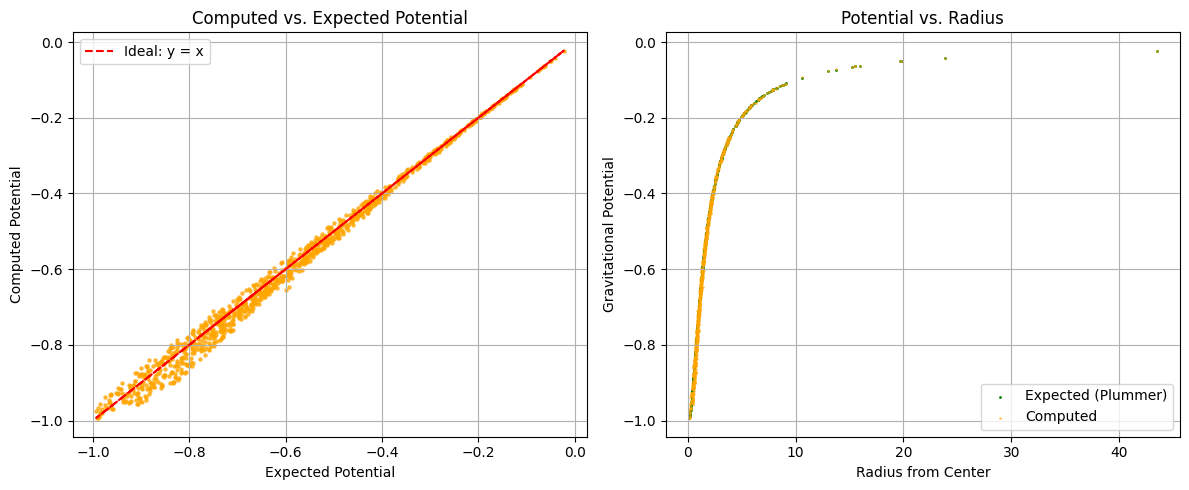

In [99]:
# Scatter plot: Computed vs. Expected potential
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(phi_analytic, phi_num, s=5,  alpha=0.7, c= 'orange')
plt.plot(phi_analytic, phi_analytic, color='red', linestyle='--', label='Ideal: y = x')
plt.xlabel('Expected Potential')
plt.ylabel('Computed Potential')
plt.title('Computed vs. Expected Potential')
plt.legend()
plt.grid(True)

# Scatter plot: Computed potential vs. radius
plt.subplot(1, 2, 2)
plt.scatter( radii, phi_analytic, s= 1, color='green', label='Expected (Plummer)')
plt.scatter(radii, phi_num, s=1, alpha=0.5, c= 'orange', label='Computed')

plt.xlabel('Radius from Center')
plt.ylabel('Gravitational Potential')
plt.title('Potential vs. Radius')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

On a 3D grid for vizualization: 

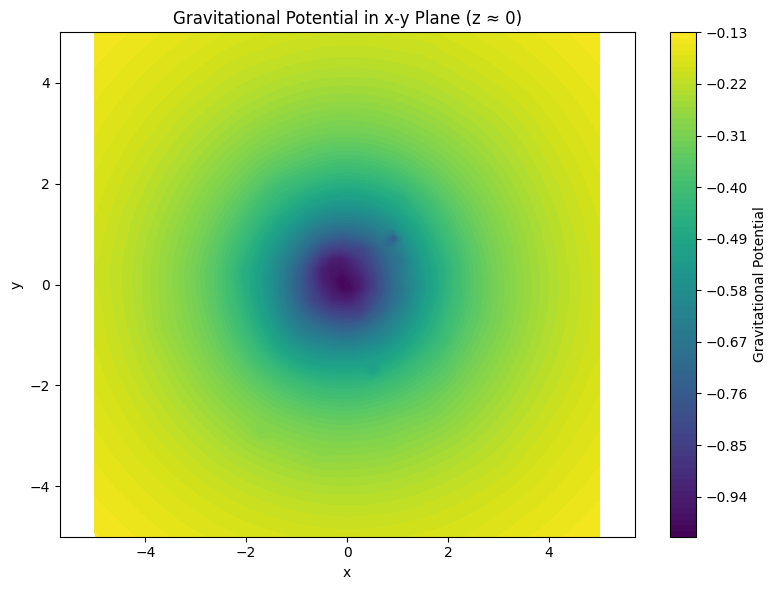

Total potential energy: -13.8643


In [104]:
def compute_potential_on_grid(positions, grid_range=5.0, grid_size=50, G=1.0, m=1.0/N):
    # Create 3D grid
    x = np.linspace(-grid_range, grid_range, grid_size)
    y = np.linspace(-grid_range, grid_range, grid_size)
    z = np.linspace(-grid_range, grid_range, grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Compute potential at each grid point
    dists = cdist(grid_points, positions)
    phi_grid = -G * m * np.sum(1.0 / dists, axis=1)
    phi_grid = phi_grid.reshape((grid_size, grid_size, grid_size))

    return X, Y, Z, phi_grid

# Run the function to compute 3D potential field
Xg, Yg, Zg, phi_grid_3d = compute_potential_on_grid(x3d, grid_range=5.0, grid_size=50)

# Visualize a central slice in the x-y plane (z ≈ 0)
central_slice = phi_grid_3d[:, :, phi_grid_3d.shape[2] // 2]

plt.figure(figsize=(8, 6))
plt.contourf(Xg[:, :, 0], Yg[:, :, 0], central_slice, levels=100, cmap='viridis')
plt.colorbar(label='Gravitational Potential')
plt.title('Gravitational Potential in x-y Plane (z ≈ 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()

U_total = 0.5 * np.sum(m * phi_grid_3d)
print(f"Total potential energy: {U_total:.4f}")

### Grid-based Poisson solvers

We shall consider the Poisson equation for the gravitational potential $\Phi$ in 2D: 

$\nabla^2 \Phi = (\delta_x^2 + \delta_y^2) \Phi = \rho$

For simplicity, we will work with the following source function:

$\rho(x,y) = \sin(2\pi x) \sin(2 \pi y)$,
which is zero on the boundary of the unit square $[0,1]^2$ and periodic in both directions

#### a) Determine the analytical solution to the Poisson equation for this source function.

Ansatz: $\Phi(x,y) = A \sin(2 \pi x) \sin(2 \pi y)$

Compute the laplacian: 
1. $\frac{\delta^2 \Phi}{\delta x^2} = A \frac{\delta^2}{\delta x^2} \sin(2 \pi x) \sin(2 \pi y) = - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) $

2. $\frac{\delta^2 \Phi}{\delta y^2} = A \frac{\delta^2}{\delta y^2} \sin(2 \pi x) \sin(2 \pi y)  = - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) $

So : 

$\nabla^2 \Phi = (\delta_x^2 + \delta_y^2) \Phi =  - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) = (-8 \pi^2 A)\sin(2 \pi x) \sin(2 \pi y) = \rho $ 


Since we are given:  
$\nabla^2 \Phi = \rho =  A \sin(2 \pi x) \sin(2 \pi y)$

Therefore, 

$- 8 \pi^2 A = 1 \rightarrow A = -\frac{1}{8\pi^2}$

So the Analytical solution is: 

$\Phi(x,y) = -\frac{1}{8\pi^2}\sin(2 \pi x) \sin(2 \pi y)$


#### b)  We shall use the conjugate gradient solver and the multigrid solver, which are all given inthe lecture notes and available via github

Use N = 64 discretisation points per dimension,and an error threshold of 10−6. 
Show the respective solutions Φ along with the residual (i.e. the difference between the left and right hand side of the Poisson equation) as images.

Poisson Solver

In [129]:
# Poisson 2D conjugate gradient solver 

# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]

@njit
def apply_A(u, h):
    """ Matrix-vector product with the Laplacian operator """
    return laplacian_2d(u) / h**2


def cg_2d_stencil(rho, h, tol=1e-8, max_iter=1000, verbose=False):
    """
    Solve the 2D Poisson equation using the matrix-free Conjugate Gradient method with a stencil-based Laplacian. This version only implements zero Dirichlet boundary conditions and a 5-point 2nd order stencil for the Laplacian.

    Parameters:
      rho (numpy.ndarray): source term.
      tol (float, optional): The tolerance for the convergence criterion. Default is 1e-8.
      max_iter (int, optional): The maximum number of iterations. Default is 1000.

    Returns:
      numpy.ndarray: The solution to the Poisson equation, excluding ghost boundaries.
    """
    N = rho.shape[0]
    u = np.zeros((N + 2, N + 2)) # Initialize solution with ghost boundaries

    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    r = rhs - apply_A(u, h)

    p = r.copy()
    for it in range(max_iter):
        Ap = apply_A(p, h)
        r_inner = r[1:-1, 1:-1]
        Ap_inner = Ap[1:-1, 1:-1]

        alpha = np.sum(r_inner * r_inner) / np.sum(p[1:-1, 1:-1] * Ap_inner)
        u[1:-1, 1:-1] += alpha * p[1:-1, 1:-1]
        r_new = r - alpha * Ap

        err = np.linalg.norm(r_new[1:-1, 1:-1])
        
        if verbose:
            print(f"Iteration {it}: error = {err : .4g}")

        if err < tol:
            break

        beta = np.sum(r_new[1:-1, 1:-1]**2) / np.sum(r_inner**2)
        p = r_new + beta * p
        r = r_new

    return u[1:-1, 1:-1]  # strip ghost boundaries

In [130]:

# Create new source term and solve 
N = 64
h = 1.0 / (N + 1)

rho_sin = np.zeros((N, N))
x = np.linspace(0, 1, N + 2)[1:-1]
y = np.linspace(0, 1, N + 2)[1:-1]
X, Y = np.meshgrid(x, y, indexing='ij')
rho_sin = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

phicg = cg_2d_stencil( rho_sin, h, tol=1e-4, verbose=True) 

Iteration 0: error =  1.406e-12


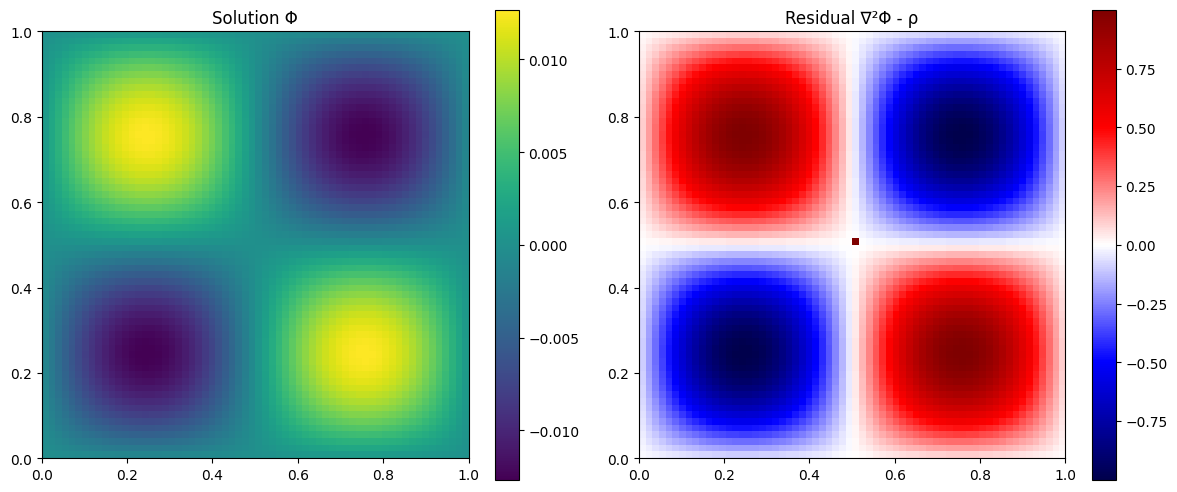

In [131]:
# Compute Residuals 
u_full = np.zeros((N+2, N+2))
u_full[1:-1, 1:-1] = phicg
residual = rho - apply_A(u_full, h)[1:-1, 1:-1]


# Plot solution and residual
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(phicg, origin='lower', extent=[0,1,0,1], cmap='viridis')
axes[0].set_title("Solution Φ")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(residual, origin='lower', extent=[0,1,0,1], cmap='seismic')
axes[1].set_title("Residual ∇²Φ - ρ")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


- Iteration 0: error =  1.406e-12 (DANGER WILL ROBINSON; DANGER)

 Multigrid solver

In [132]:
# Multigrid solver
# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u, h):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return (u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]) / h**2


@njit
def gauss_seidel_sweep(u, f, h, N, icolor):
  """
  Perform a single in-place Gauss-Seidel sweep on the grid.

  Parameters:
  u : ndarray
    The current solution grid.
  f : ndarray
    The source term grid.
  h : float
    The grid spacing.
  N : int
    The number of interior grid points per dimension.
  icolor : int
    The color of the sweep (0 for red, 1 for black).

  Returns:
  ndarray
    The updated solution grid after the Gauss-Seidel sweep.
  """
  for i in range(1,N+1):
    for j in range(1,N+1):
      if (i+j)%2==icolor:
        u[i,j] = 0.25*(u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1]-h**2*f[i,j])
  return u



@njit
def twogrid( phi, rho, h, N, nsmooth=4 ):
    """
    Perform a two-grid V-cycle to solve the Poisson equation.

    Parameters:
    phi : ndarray
      The current solution grid.
    rho : ndarray
      The source term grid.
    h : float
      The grid spacing.
    N : int
      The number of interior grid points per dimension.
    nsmooth : int, optional
      The number of Gauss-Seidel smoothing iterations (default is 4).

    Returns:
    ndarray
      The updated solution grid after the two-grid V-cycle.
    """
    # break the recursion if we are at the coarsest grid
    # solve directly since only one unknown
    if N == 1:
      phi[1,1] = -0.25*h**2*rho[1,1]
      return phi

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    # compute the residual on the fine grid
    resid = laplacian_2d(phi,h) - rho

    # restrict the residual to the coarse grid
    resid_coarse = np.zeros((N//2+2,N//2+2))
    resid_coarse[1:-1,1:-1] = 0.25*(resid[1:-1:2,1:-1:2] + resid[2:-1:2,1:-1:2] \
                                  + resid[1:-1:2,2:-1:2] + resid[2:-1:2,2:-1:2])

    # solve the coarse equation to get the coarse grid correction
    corr_coarse = np.zeros_like(resid_coarse)
    corr_coarse = twogrid( corr_coarse, resid_coarse, h*2, N//2, nsmooth )

    # correct the solution on the fine grid using the coarse grid correction
    phi[1:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[1:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    return phi


def solve_poisson_2d_multigrid(rho, h, tol=1e-6, nsmooth=4, maxit=20, verbose=False):
    """Solves the 2D Poisson equation using the multigrid method
          with zero Dirichlet boundary conditions.
    
    Parameters:
          rho (ndarray): density, shape (N+2,N+2)
          h (float): grid spacing
          N (int): number of grid points
          tol (float, optional): error tolerance. Defaults to 1e-6.
    
    Returns:
          ndarray: potential, shape (N+2,N+2)
    """
    N = rho.shape[0]
    phi = np.zeros((N+2,N+2))
    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    for it in range(maxit):
      phi_old = phi.copy()
      phi = twogrid(phi, rhs, h, N, nsmooth)
      err = np.max(np.abs(phi-phi_old)) # determine L_infinity error
      if verbose:
        print(f'Iteration {it}: Linf error = {err:4g}')
      if err < tol:
         break
    if err > tol:
      print(f'Warning: did not converge in {it} iterations, final error = {err:4g}')
    return phi

Iteration 0: Linf error = 0.0137365
Iteration 1: Linf error = 0.00161735
Iteration 2: Linf error = 0.000377477
Iteration 3: Linf error = 0.000100167
Iteration 4: Linf error = 3.03261e-05
Iteration 5: Linf error = 1.08917e-05
Iteration 6: Linf error = 4.5807e-06
Iteration 7: Linf error = 2.02059e-06
Iteration 8: Linf error = 8.90217e-07


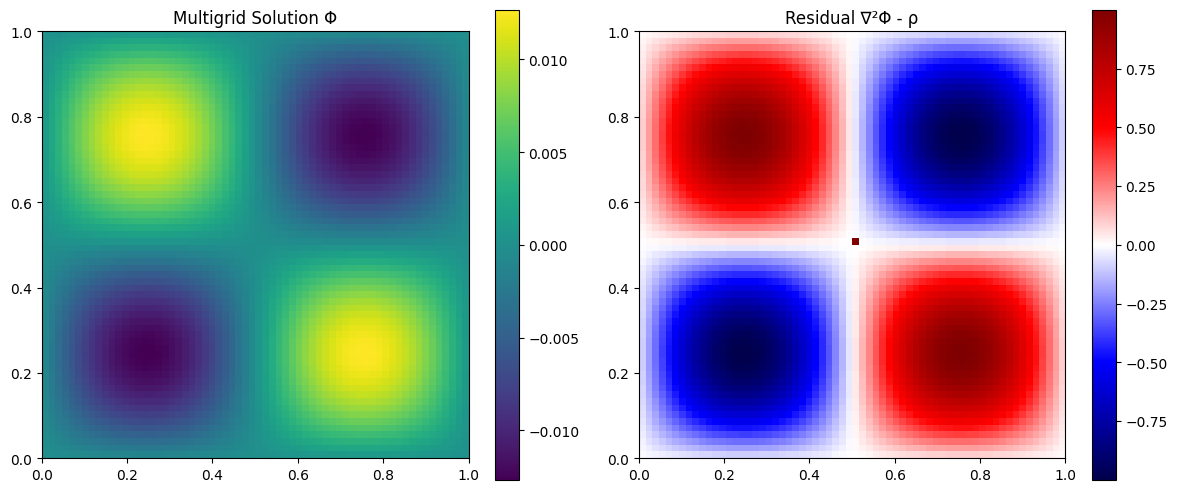

In [133]:
# Example usage: single point source in the center
N = 64
h = 1.0 / (N + 1)

# Create new source term and solve again using both methods
rho_sin = np.zeros((N, N))
x = np.linspace(0, 1, N + 2)[1:-1]
y = np.linspace(0, 1, N + 2)[1:-1]
X, Y = np.meshgrid(x, y, indexing='ij')
rho_sin = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

phimg = solve_poisson_2d_multigrid(rho_sin, h, tol=1e-6, verbose=True) 


# Compute Residuals
residual = rho - laplacian_2d(phimg, h)[1:-1, 1:-1]


# Plot results 


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(phimg[1:-1, 1:-1], origin='lower', extent=[0,1,0,1], cmap='viridis')
axes[0].set_title("Multigrid Solution Φ")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(residual, origin='lower', extent=[0,1,0,1], cmap='seismic')
axes[1].set_title("Residual ∇²Φ - ρ")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


Very huge errors, why?
- 8 Iterations are needed to reach the error threshold of $10^{-6}$

##### Compare the solution against the analytical solutionfrom part a) by computing the absolute difference and plotting it as an image.  How does it compare to the error threshold.

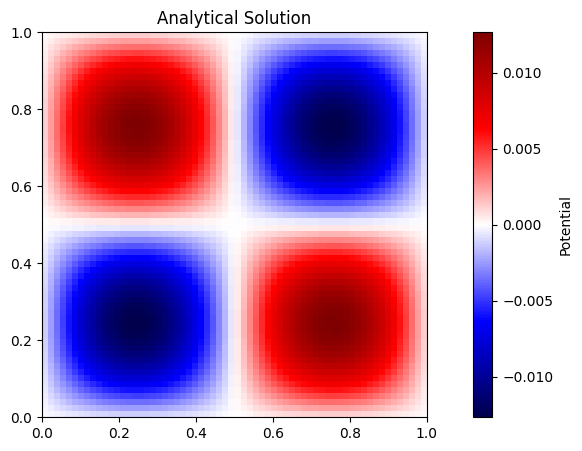

In [138]:
# Compute analytical solution: Φ(x, y) = -1 / (8π²) * sin(2πx) * sin(2πy)
def analytical_solution(N):
    x = np.linspace(0, 1, N + 2)[1:-1]
    y = np.linspace(0, 1, N + 2)[1:-1]
    X, Y = np.meshgrid(x, y, indexing='ij')
    return -(1 / (8 * np.pi**2)) * np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

# Create new source term and solve again using both methods
rho_sin = np.zeros((N, N))
x = np.linspace(0, 1, N + 2)[1:-1]
y = np.linspace(0, 1, N + 2)[1:-1]
X, Y = np.meshgrid(x, y, indexing='ij')
rho_sin = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

# Solve with CG method
phi_cg = cg_2d_stencil(rho_sin, h, tol=1e-6, verbose=False)

# Solve with Multigrid method
phi_mg = solve_poisson_2d_multigrid(rho_sin, h, tol=1e-6, verbose=False)[1:-1, 1:-1]

# Analytical solution
phi_exact = analytical_solution(N)

# Compute absolute differences
diff_cg = np.abs(phi_cg - phi_exact)
diff_mg = np.abs(phi_mg - phi_exact)

plt.figure(figsize=(12, 5))
plt.imshow(phi_exact, origin='lower', extent=[0,1,0,1], cmap='seismic')
plt.title("Analytical Solution")
plt.colorbar(label='Potential') 

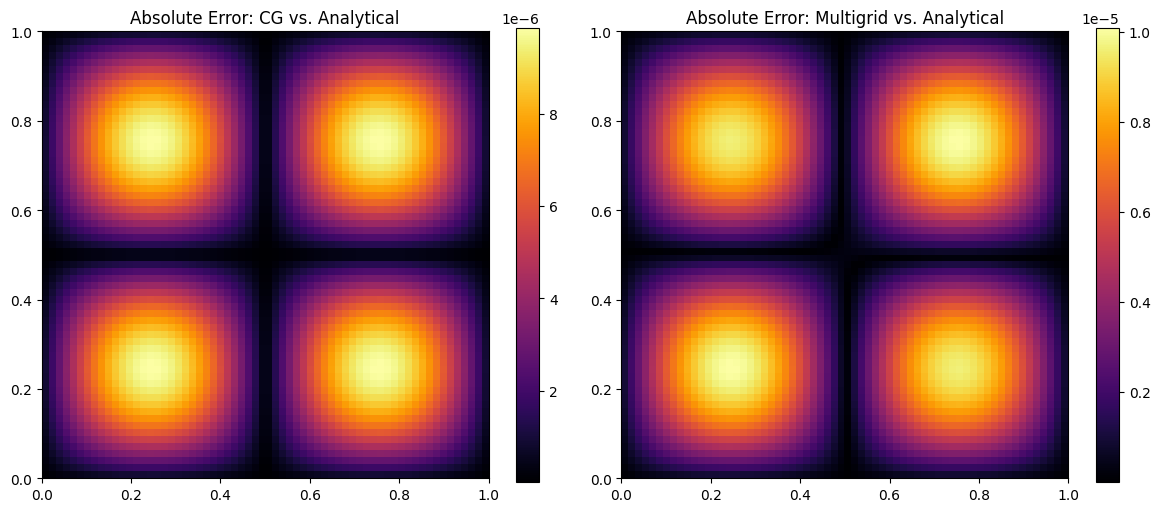

In [139]:

# Plot the absolute errors
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(diff_cg, origin='lower', extent=[0,1,0,1], cmap='inferno')
axes[0].set_title("Absolute Error: CG vs. Analytical")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(diff_mg, origin='lower', extent=[0,1,0,1], cmap='inferno')
axes[1].set_title("Absolute Error: Multigrid vs. Analytical")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

#### Comparison

We see a low overall error: 
- The bars are at the scale of $10^{-5 }$, indicating that both numerical methods are very accurate.

- The CG method appears to slightly outperform the multigrid in terms of peak accuracy (lower maximum error). 

- The error is largest near the maxima/minima of the sine function — i.e., where the potential changes most rapidly. This is typical in finite-difference methods: errors accumulate more where second derivatives are largest.

- The error plots show no noise — just a smooth structure, indicating good numerical stability and systematic discretization error rather than random artifacts.

##### Compared to the Threshold:  (?????)
 - The solvers did reach the threshold in terms of internal convergence (residual norm or solution update). However, the global error compared to the analytical solution is slightly above the set tolerance. (??????)


##### c) Determine the fourth order accurate finite difference approximation to the 2D Laplacian using the notebook provided for Chapter 2. How many ghost points have to be added now? Does anything have to be changed for the zero Dirichlet boundary condition when a fourth order stencil is used? 